In [330]:
import random
from jupyturtle import *

def draw_plant(instructions, angle, length, angle_var=5, length_decay=0.8):
    make_turtle(delay=0, width=300, height=500)
    set_heading(270)
    jp(150, 480)
    set_color("gray")
    hide()

    stack = []
    for cmd in instructions:
        if cmd == 'F':
            fd(length)
        elif cmd == '+':
            rt(angle + random.uniform(-angle_var, angle_var))
        elif cmd == '-':
            lt(angle + random.uniform(-angle_var, angle_var))
        elif cmd == '[':
            t = get_turtle()
            stack.append((t.position, t.heading, length))
            length *= length_decay
        elif cmd == ']':
            pos, head, length = stack.pop()
            jp(pos.x, pos.y)
            set_heading(head)

def draw_plant_contextual(instructions, angle, length, length_decay=0.8):
    make_turtle(delay=0, width=400, height=400)
    set_heading(270)
    jp(200, 380)
    set_color("gray")
    hide()

    stack = []
    last_cmd = '1'
    for cmd in instructions:
        if cmd == 'F':
            fd(length)
        elif cmd in ['1', '0']:
            last_cmd = cmd
        elif cmd == '[':
            t = get_turtle()
            stack.append((t.position, t.heading, length))
            direction = 1 if last_cmd == '1' else -1
            set_heading(t.heading + (angle * direction))
            length *= length_decay
        elif cmd == ']':
            pos, head, length = stack.pop()
            jp(pos.x, pos.y)
            set_heading(head)


In [331]:
import random

def gen_lsystem_stochastic(axiom, rules, iterations):
    current = axiom
    for _ in range(iterations):
        next_str = []
        for char in current:
            if char in rules:
                if isinstance(rules[char], list):
                    next_str.append(random.choice(rules[char])) # stochastic choice
                else:
                    next_str.append(rules[char])
            else:
                next_str.append(char) # might not need this
        current = ''.join(next_str)
    return current

def gen_plant_stochastic():
    config = {
        'axiom': 'F',
        'rules': {
            'F': ['F[+F]F[-F]F', 'F[+F]F', 'F[-F]F'],  # stochastic branching
            'X': 'F[@-FX]+FX'  # flower production rule
        },
        'iterations': 4,
        'angle': 30,
        'length': 15,
        'thickness': 5,
        'angle_var': 10,
        'length_decay': 0.7
    }
    generated_string = gen_lsystem_stochastic(config['axiom'], config['rules'], config['iterations'])
    print(generated_string)    
    draw_plant(generated_string, config['angle'], config['length'], config['angle_var'], config['length_decay'])
    return generated_string

In [332]:
def get_context(c_string, idx):
    env_context = '1'
    ignore = ['[', ']', '+', '-', 'F']

    # find left context
    left_context = env_context
    i = idx
    while i > 0:
        if c_string[i-1] in ['+', '-', 'F']:   # left neighbor is not valid context
            i -= 1
        else:
            if c_string[i-1] == '[':          # left neighbor is an opening bracket
                depth = 0
                j = i - 2
                while j >= 0 and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == ']':
                        depth += 1
                    elif c_string[j] == '[':
                        depth -= 1
                    j -= 1
                if j >= 0:
                    left_context = c_string[j]
            elif c_string[i-1] == ']':        # left neighbor is a closing bracket
                depth = -1
                j = i - 2
                while j >= 0 and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == '[':
                        depth += 1
                    elif c_string[j] == ']':
                        depth -= 1
                    j -= 1
                if j >= 0:
                    left_context = c_string[j]
            else:                             # left neighbor is a normal character
                left_context = c_string[i-1]
            break
    
    # find right context
    right_context = env_context
    i = idx
    while i < len(c_string) - 1:
        if c_string[i+1] in ['+', '-', 'F']:       # right neighbor is not valid context
            i += 1
        else:
            if c_string[i+1] == ']':          # right neighbor is a closing bracket
                right_context = env_context
            elif c_string[i+1] == '[':        # right neighbor is an opening bracket
                depth = 1
                j = i + 2
                while j < len(c_string) and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == '[':
                        depth += 1
                    elif c_string[j] == ']':
                        depth -= 1
                    j += 1
                if j < len(c_string):
                    right_context = c_string[j]
            else:                             # right neighbor is a normal character
                right_context = c_string[i+1]
            break
    
    return left_context, c_string[idx], right_context

In [333]:
def gen_lsystem_contextual(axiom, rules, iterations):
    current = axiom
    for _ in range(iterations):
        next_str = []
        for i, char in enumerate(current):
            if char not in ['[', ']', '+', '-', 'F']: # char is context-dependent
                context = get_context(current, i)
                if context in rules:
                    next_str.append(rules[context])
                else:
                    print(f'!!! No rule for {context}')
            elif char in ['+', '-']:                  # char is a pitch modifier
                next_str.append(rules[char])
            else:                                     # char is unchanged
                next_str.append(char)
        current = ''.join(next_str)
    return current

def gen_plant_contextual():
    config = {
        'axiom': 'F1F1',
        'rules': {
            ('0', '0', '0'): '0',
            ('0', '0', '1'): '1[+F1]',
            ('0', '1', '0'): '1',
            ('0', '1', '1'): '1',
            ('1', '0', '0'): '0',
            ('1', '0', '1'): '1F1',
            ('1', '1', '0'): '1',
            ('1', '1', '1'): '0',
            '+': '-',
            '-': '+',
        },
        'iterations': 22,
        'angle': 25,
        'length': 10,
        'thickness': 5,
        'length_decay': 0.9
    }
    generated_string = gen_lsystem_contextual(config['axiom'],
                                              config['rules'],
                                              config['iterations'])
    print(generated_string)    
    draw_plant_contextual(generated_string, config['angle'],
                                            config['length'],
                                            config['length_decay'])
    return generated_string

In [334]:
generated_string = gen_plant_contextual()

F0F0F1[+F1F1]F1F1[-F1F0][+F0F0F1[+F1]]F1[-F1F1F1[-F0]F1[+F1F1][-F0F0F0]]F0F0F1[+F1F1][+F1F0F1[+F1]F1[-F0][+F1F1F1]][-F0[-F1[+F1]F1[-F0]]F0F1[+F1][+F0F0F1[+F1]]F1[-F0F0][-F0F1[+F1]F1[-F0F0]]]F0[-F1F0][+F1[-F1F1F1[-F0]]F0[+F1F0F1[+F1]]F1[+F1][-F1F0F0F0[+F1F1][-F0F0F0]]F1[-F0]F1[+F1F1]F0[-F1F0][+F1F1F1[-F1[-F1F1F1[-F0]]]F1[-F0][-F0F0F0][+F1F1F1[-F0]F1[+F1F1]]]]F0[+F0F1[+F1]]F0F1[+F1][-F1F0F0]F1[+F1F1F1[-F0]F0[+F0F1[+F1]]]F0F1[+F1]F1[-F0][+F1F1F1][-F1F0F1[+F1]F1[-F0F0]][+F0[-F0][+F1[+F1F1]]F0[+F1F1][-F0F0F0]F0[+F0F0F0[+F1F1]]][-F0[-F0]F0[+F1F1]F0[-F0F0]F0F0[+F1F1F1][-F0F1[+F1]F1[-F0]]F1[+F0F0F0[+F1F1F1]][-F1F1F1[-F0]F1[+F0F1[+F1]]F0F1[+F1][-F1F0F0]]][+F1F1F1[-F0]F0[+F1F1][+F0[+F0F1[+F1]][+F0[-F1[+F1]F1[-F0]]F1[+F1]F1[+F0F0F1[+F1]]]]F1[-F0F0][-F1[-F1F1F1[-F0]]F0[+F1[-F0]F0[+F1F1]]F1[+F1]F1[-F0][-F0[-F0][+F1[+F1F1]]F0[+F1F1][-F0F0F0]]]F0[+F1F1F1]F0[-F1[+F1]F1[-F0]]F1[+F1]F1[-F0][+F1F0F1[+F1]][-F0[-F0]F0[+F1F1]F1[-F0F0]][+F0F1[+F1]F1[-F0]F1[+F0F1[+F1]]F0F1[+F1][-F1F0F0][+F1[+F1]F1[-F0]F0[+F1F

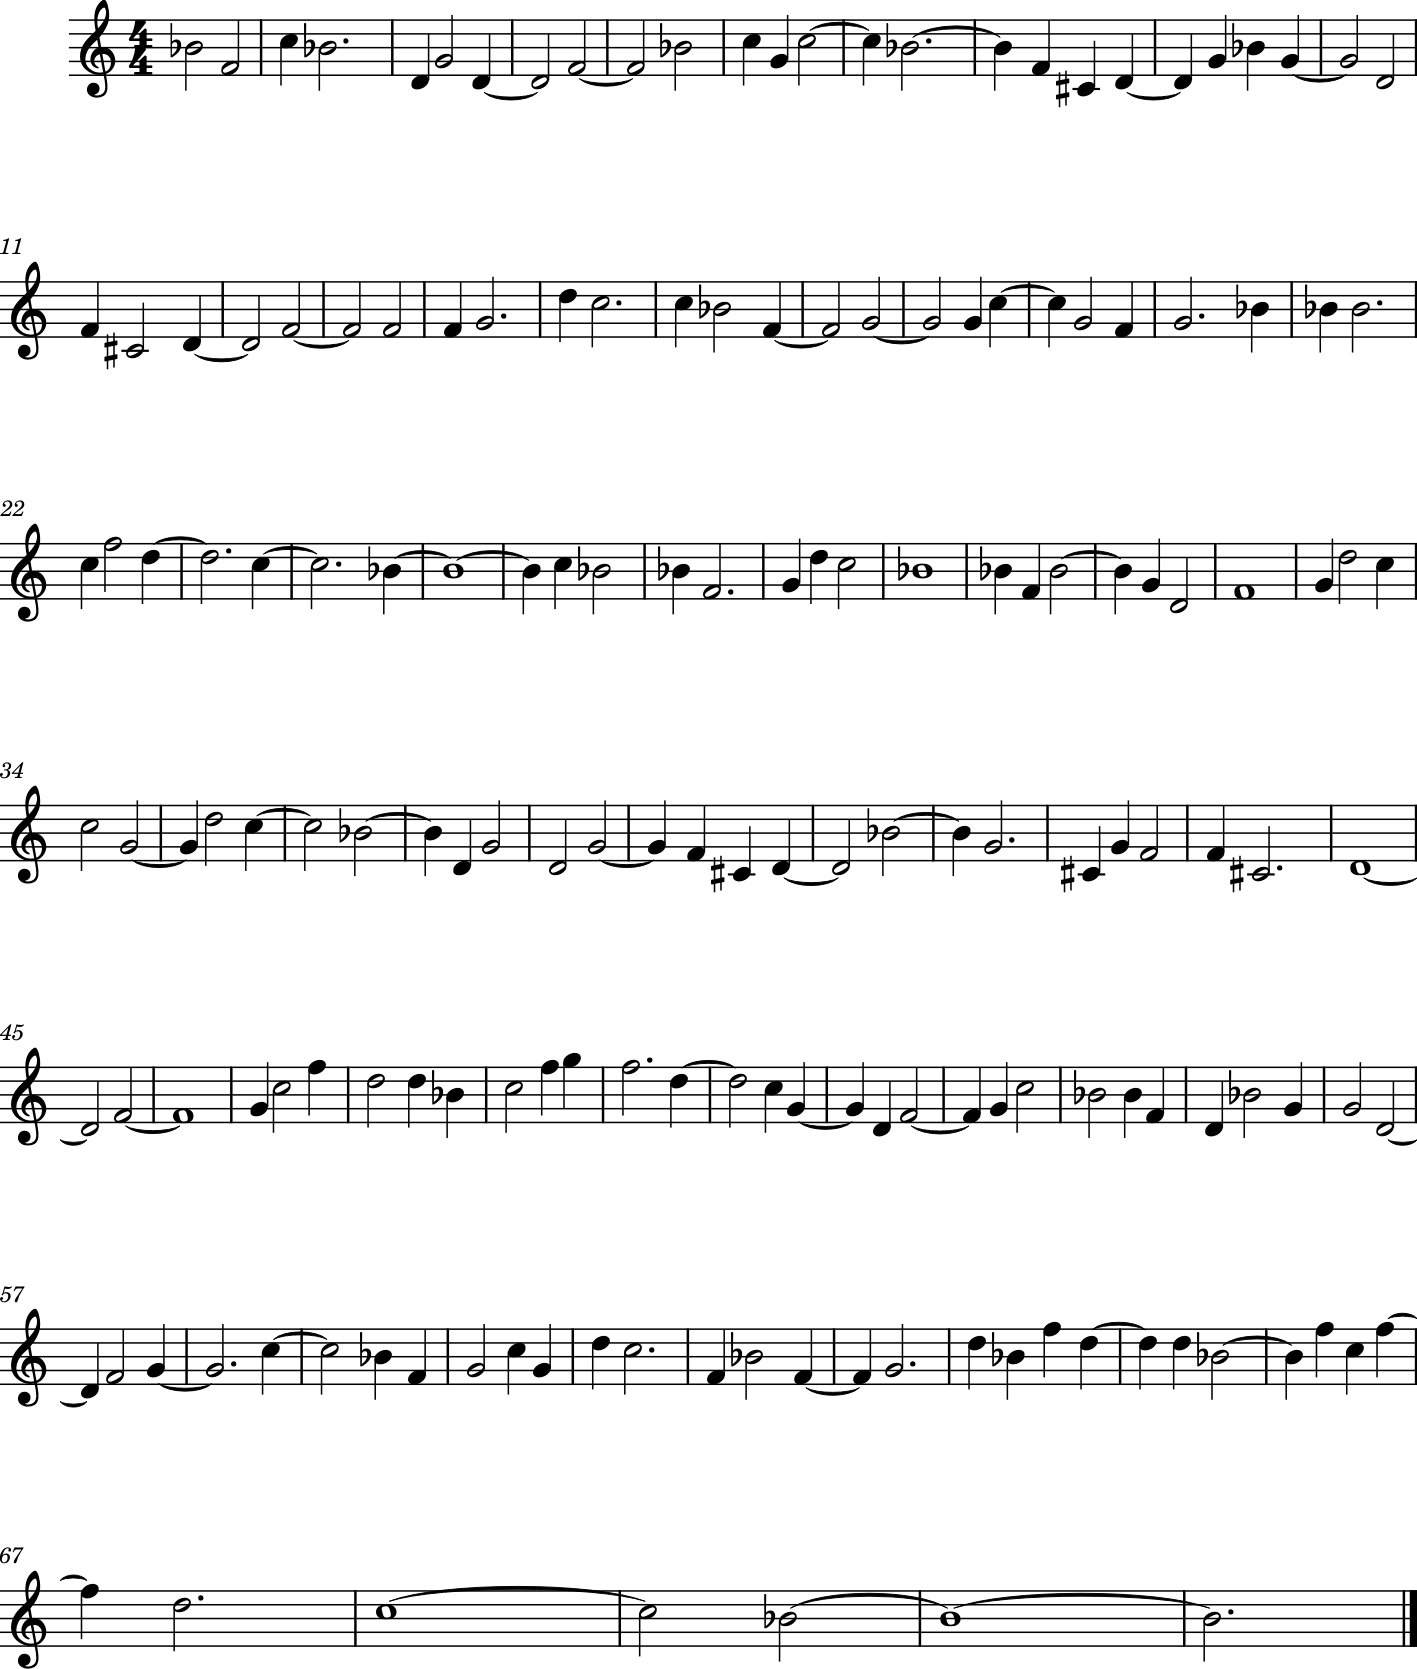

In [335]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe"
us['musicxmlPath'] = "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe"

def generate_music_stochastic(lsystem_string):
    s1 = stream.Stream()
    F_major = scale.WeightedHexatonicBlues('G')
    scale_notes = F_major.getPitches('G2', 'G6')
    current_note_idx = len(scale_notes) // 2  # Start in middle of range
    current_duration = 0
    stack = []

    # Process each character in the L-system string
    for char in lsystem_string:
        if char == 'F':
            current_duration += 1.0  # Add quarter note duration
        elif char == '+':
            current_note_idx = (current_note_idx + 1) % (len(scale_notes) - 1)
        elif char == '-':
            current_note_idx = abs(1 - current_note_idx) % (len(scale_notes) - 1)
        elif char == '[':
            stack.append((current_note_idx, current_duration))
            current_duration = 0
        elif char == ']':
            if current_duration > 0:
                n = note.Note(scale_notes[current_note_idx], quarterLength=current_duration)
                s1.append(n)
            current_note_idx, current_duration = stack.pop()

    return s1

s1 = generate_music_stochastic(generated_string)

s1.show()

In [336]:
for element in s1.recurse():
    if hasattr(element, 'duration'):
        element.duration.quarterLength /= 2.0
    if hasattr(element, 'offset'):
        element.offset /= 4.0

s1.write('midi', 'comp1.mid')
s1.show('midi')


---
### Steedman Time

In [337]:
class Terminal:
    def __init__(self, root, isMinor, isDom7, sD, dom, sT, flatST, mD, duration):
        self.duration = duration # in quarter notes
        self.root = root         # root chord
        self.isMinor = isMinor   # default: 'maybe'
        self.isDom7 = isDom7     # default: 'maybe'
        self.sD = sD             # chord rooted at subdominant of x
        self.dom = dom           # chord at the dominant of x
        self.sT = sT             # supertonic of x
        self.flatST = flatST     # flat supertonic of x
        self.mD = mD             # mediant of x
        self.rootHasChanged = False
    
    def print(self):
        out = self.root
        out += 'm' if self.isMinor == 'yes' else ''
        out += '7' if self.isDom7 == 'yes' else ''
        out = ("SubDom " if self.sD else "") + out
        out = ("Dom " if self.dom else "") + out
        out = ("SupTonic " if self.sT else "") + out
        out = ("FlatSupTonic " if self.flatST else "") + out
        out = ("Mediant " if self.mD else "") + out
        out += f" ({self.duration})"
        return out
    
def tm(root, isMinor='maybe', isDom7='maybe',
       sD=False, dom=False, sT=False, flatST=False, mD=False,
       duration=-1):
    return Terminal(root, isMinor, isDom7, sD, dom, sT, flatST, mD, duration)

def equal_terms(t1, t2):
    out = t2.root == 'x' or t2.root == 'w' or t1.root == t2.root
    out = out and (t1.isMinor == 'maybe' or t2.isMinor == 'maybe' or t1.isMinor == t2.isMinor)
    out = out and (t1.isDom7 == 'maybe' or t2.isDom7 == 'maybe' or t1.isDom7 == t2.isDom7)
    out = out and t1.sD == t2.sD
    out = out and t1.dom == t2.dom
    out = out and t1.sT == t2.sT
    out = out and t1.flatST == t2.flatST
    out = out and t1.mD == t2.mD
    return out

class Rule:
    def __init__(self, lhs, rhs):
        self.lhs = lhs
        self.rhs = rhs

rule0 = Rule([tm('S12', duration=4*12)], [
    tm('I', isDom7='no'),                 # I(m)
    tm('I', isMinor='no', isDom7='yes'),  # I7
    tm('IV', isDom7='no'),                # IV(m)
    tm('I', isDom7='no'),                 # I(m)
    tm('V', isMinor='no', isDom7='yes'),  # V7
    tm('I', isDom7='no')                  # I(m)
])

rule1  = Rule([tm('x')], [tm('x', isDom7='no'), tm('x')])
rule2  = Rule([tm('x')], [(tm('x')), tm('x', sD=True)])
rule3a = Rule([tm('w'), tm('x', isMinor='no',  isDom7='yes')], [tm('x', dom=True, isDom7='yes'), tm('x')])
rule3b = Rule([tm('w'), tm('x', isMinor='yes', isDom7='yes')], [tm('x', dom=True, isMinor='no'),  tm('x')])
rule4  = Rule([tm('x', dom=True, isMinor='no',  isDom7='yes'), tm('x')], [tm('x', flatST=True), tm('x')])
rule5  = Rule(3 * [tm('x', isMinor='no',  isDom7='no')],  [tm('x'), tm('x', sT=True), tm('x', mD=True)])

rules = [rule1, rule2, rule3a, rule3b, rule4, rule5]

In [338]:
roman_to_degree = {
    'I': 1, 'II': 2, 'III': 3, 'IV': 4,
    'V': 5, 'VI': 6, 'VII': 7,
}

degree_to_roman = {
    1: 'I', 2: 'II', 3: 'III', 4: 'IV',
    5: 'V', 6: 'VI', 7: 'VII'
}

def get_degree(tonic):
    modifier = 0
    while tonic.startswith('b'):
        tonic = tonic[1:]
        modifier -= 1
    while tonic.startswith('#'):
        tonic = tonic[1:]
        modifier += 1
    return roman_to_degree[tonic] + modifier, modifier

def get_roman(degree, modifier):
    out = degree_to_roman[degree]
    while modifier < 0:
        out = 'b' + out
        modifier += 1
    while modifier > 0:
        out = '#' + out
        modifier -= 1
    return out

def get_subdominant(tonic):
    degree, modifier = get_degree(tonic)
    subdominant_degree = (degree - 1 + 3) % 7 + 1 # 4th degree relative to tonic
    return get_roman(subdominant_degree, modifier)

def get_dominant(tonic):
    degree, modifier = get_degree(tonic)
    dominant_degree = (degree - 1 + 4) % 7 + 1 # 5th degree relative to tonic
    return get_roman(dominant_degree, modifier)

def get_supertonic(tonic):
    degree, modifier = get_degree(tonic)
    supertonic_degree = (degree - 1 + 1) % 7 + 1 # 2nd degree relative to tonic
    return get_roman(supertonic_degree, modifier)

def get_flat_supertonic(tonic):
    degree, modifier = get_degree(tonic)
    supertonic_degree = (degree - 1 + 1) % 7 + 1 # 2nd degree relative to tonic
    return get_roman(supertonic_degree, modifier - 1) # flatten

def get_mediant(tonic):
    degree, modifier = get_degree(tonic)
    mediant_degree = (degree - 1 + 5) % 7 + 1 # 6th degree relative to tonic
    return get_roman(mediant_degree, modifier)

In [358]:
import random

global_rule_prob = 0.25

def generate_seed(num_iters, num_rules):
    out = ""
    for _ in range(num_iters):
        out += str(random.randint(1, num_rules))
    return out

def apply_rule(terms, rule):
    new_terms = []
    # if lhs has one term, rhs' durations are an equal division
    # additionally, use simple pattern matching for substitution
    if len(rule.lhs) == 1:
        rule_lhs = rule.lhs[0]
        for term in terms:
            if equal_terms(term, rule_lhs):
                if term.root == 'S12' or random.random() < global_rule_prob:

                    rhs_durations = term.duration // len(rule.rhs)

                    print(f"applying to {term.root} with duration {term.duration}")
                    for rule_rhs_term in rule.rhs:

                        if rule_rhs_term.root == 'x':
                            rhs_term_root = term.root
                        else:
                            rhs_term_root = rule_rhs_term.root

                        rootChange = False
                        if rule_rhs_term.sD:
                            rhs_term_root = get_subdominant(rhs_term_root)
                            rootChange = True
                        elif rule_rhs_term.dom:
                            rhs_term_root = get_dominant(rhs_term_root)
                            rootChange = True
                        elif rule_rhs_term.sT:
                            rhs_term_root = get_supertonic(rhs_term_root)
                            rootChange = True
                        elif rule_rhs_term.flatST:
                            rhs_term_root = get_flat_supertonic(rhs_term_root)
                            rootChange = True
                        elif rule_rhs_term.mD:
                            rhs_term_root = get_mediant(rhs_term_root)
                            rootChange = True

                        termIsMinor = 'maybe'
                        if rule_rhs_term.isMinor == 'yes' or term.isMinor == 'yes':
                            termIsMinor = 'yes'
                        elif rule_rhs_term.isMinor == 'no' or term.isMinor == 'no':
                            termIisMinor = 'no'
                        
                        termIsDom7 = 'maybe'
                        if rule_rhs_term.isDom7 == 'yes' or term.isDom7 == 'yes':
                            termIsDom7 = 'yes'
                        elif rule_rhs_term.isDom7 == 'no' or term.isDom7 == 'no':
                            termIsDom7 = 'no'

                        new_terms.append(tm(rhs_term_root,
                                            isMinor=termIsMinor,
                                            isDom7=termIsDom7,
                                            duration=rhs_durations))
                        if rootChange:
                            new_terms[-1].rootHasChanged = True
                else:
                    new_terms.append(term)
            else:
                new_terms.append(term)

    # if lhs has 2 or more terms, rhs matches lhs' durations
    # use more complex pattern matching for substitution
    else:
        i = 0
        while i < len(terms):
            if i + len(rule.lhs) <= len(terms):
                # Check if sequence of terms matches rule.lhs
                matches = True
                for j in range(len(rule.lhs)):
                    if not equal_terms(terms[i + j], rule.lhs[j]):
                        matches = False
                        break
                    if rule.lhs[0].root == 'w':
                        if terms[i].dom or terms[i].rootHasChanged:
                            matches = False
                            break
                
                if matches and (random.random() < global_rule_prob):
                    print(f"applying to sequence starting at {terms[i].root}")
                    # Apply rule and substitute
                    for j, rule_rhs_term in enumerate(rule.rhs):
                        if rule_rhs_term.root == 'x' or rule_rhs_term.root == 'w':
                            rhs_term_root = terms[i].root
                        else:
                            rhs_term_root = rule_rhs_term.root
                        
                        # Apply transformations
                        rootChange = False
                        if rule_rhs_term.sD:
                            rhs_term_root = get_subdominant(rhs_term_root)
                            rootChange = True
                        if rule_rhs_term.dom:
                            rhs_term_root = get_dominant(rhs_term_root)
                            rootChange = True
                        if rule_rhs_term.sT:
                            rhs_term_root = get_supertonic(rhs_term_root)
                            rootChange = True
                        if rule_rhs_term.flatST:
                            rhs_term_root = get_flat_supertonic(rhs_term_root)
                            rootChange = True
                        if rule_rhs_term.mD:
                            rhs_term_root = get_mediant(rhs_term_root)
                            rootChange = True
                        
                        new_terms.append(tm(rhs_term_root,
                                          isMinor=terms[i].isMinor,
                                          isDom7=terms[i].isDom7,
                                          duration=terms[i+j].duration))
                        if rootChange:
                            new_terms[-1].rootHasChanged = True
                    
                    i += len(rule.lhs)
                else:
                    new_terms.append(terms[i])
                    i += 1
            else:
                new_terms.append(terms[i])
                i += 1
    return new_terms

In [359]:
iterations = 5
seed = generate_seed(iterations, len(rules))
print(f"seed: [{seed}]\n")

axiom = [tm('S12', isMinor='yes', duration=4*12)]
axiom = apply_rule(axiom, rule0)
print("axiom S12 -->")
print (' | '.join([term.print() for term in axiom]))

for i in range(iterations):
    print(f"\n----- iteration {i+1} -----")

    pick_rule = int(seed[i])

    print_rule = pick_rule
    if pick_rule == 3:
        print(f"rule 3a")
    elif pick_rule == 4:
        print(f"rule 3b")
    elif pick_rule > 4:
        print(f"rule {pick_rule - 1}")
    else:
        print(f"rule {pick_rule}")

    axiom = apply_rule(axiom, rules[pick_rule - 1])

    print(' | '.join([term.print() for term in axiom]))


seed: [11133]

applying to S12 with duration 48
axiom S12 -->
Im (8) | Im7 (8) | IVm (8) | Im (8) | Vm7 (8) | Im (8)

----- iteration 1 -----
rule 1
applying to I with duration 8
applying to V with duration 8
applying to I with duration 8
Im (4) | Im (4) | Im7 (8) | IVm (8) | Im (8) | Vm7 (4) | Vm7 (4) | Im (4) | Im (4)

----- iteration 2 -----
rule 1
applying to IV with duration 8
applying to I with duration 4
Im (4) | Im (4) | Im7 (8) | IVm (4) | IVm (4) | Im (8) | Vm7 (4) | Vm7 (4) | Im (2) | Im (2) | Im (4)

----- iteration 3 -----
rule 1
applying to I with duration 2
Im (4) | Im (4) | Im7 (8) | IVm (4) | IVm (4) | Im (8) | Vm7 (4) | Vm7 (4) | Im (2) | Im (1) | Im (1) | Im (4)

----- iteration 4 -----
rule 3a
Im (4) | Im (4) | Im7 (8) | IVm (4) | IVm (4) | Im (8) | Vm7 (4) | Vm7 (4) | Im (2) | Im (1) | Im (1) | Im (4)

----- iteration 5 -----
rule 3a
Im (4) | Im (4) | Im7 (8) | IVm (4) | IVm (4) | Im (8) | Vm7 (4) | Vm7 (4) | Im (2) | Im (1) | Im (1) | Im (4)


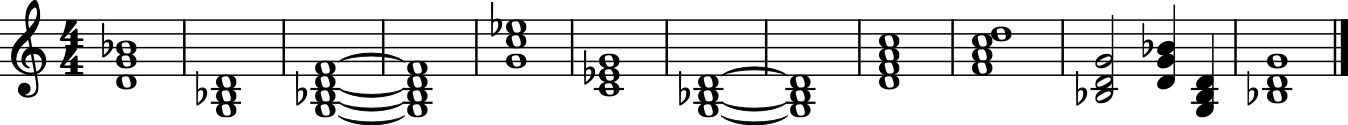

In [360]:
from music21 import *
import random

def create_chord_from_term(term):
    term_root = term.root

    if term.isMinor == 'yes':
        term_root = term_root.lower()

    if term.isDom7 == 'yes':
        term_root += '7'

    # Convert roman numeral to chord
    root = roman.RomanNumeral(term_root, 'G')
    
    # Set duration
    root.quarterLength = term.duration
    return root

s2 = stream.Stream()
for term in axiom:
    chord = create_chord_from_term(term)
    chord.inversion(random.choice([0, 1, 2]))
    chord.transpose(-12, inPlace=True)
    s2.append(chord)

s2.show()

In [361]:
s2.show('midi')